# Script for American Put Option Valuation by MCS/LSM
# in H93 and CIR85 model

### Examples from Medvedev & Scaillet (2010):
### "Pricing American Options Under Stochastic Volatility and Stochastic Interest Rates."

source code from  [10_mcs/SVSI_american_mcs.py](https://github.com/yhilpisch/dawp/blob/master/dawp/book/10_mcs/SVSI_american_mcs_10_5.py)

(c) Dr. Yves J. Hilpisch
Derivatives Analytics with Python

In [30]:
import gc
import sys
#sys.path.append('09_gmm/')
import math
import string
import numpy as np
import pandas as pd
import itertools as it
from scipy.integrate import quad
from datetime import datetime
#from BCC_option_valuation import H93_call_value
#from H93_european_mcs import SRD_generate_paths
#from CIR_zcb_valuation_gen import B
from time import time

In [34]:
# H93_stuff

def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    ''' Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: integration function.
    Parameter definitions see function H93_call_value.'''
    char_func_value = H93_char_func(u - 1j * 0.5, T, r, kappa_v,
                                    theta_v, sigma_v, rho, v0)
    int_func_value = 1 / (u ** 2 + 0.25) \
            * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return int_func_value


def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    ''' Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value.'''
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v)
            ** 2 - sigma_v ** 2 * (-u * 1j - u ** 2))
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) \
          / (kappa_v - rho * sigma_v * u * 1j - c2)
    H1 = (r * u * 1j * T + (c1 / sigma_v ** 2)
          * ((kappa_v - rho * sigma_v * u * 1j + c2) * T
                - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))))
    H2 = ((kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v ** 2
          * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T))))
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value


def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    ''' Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach.
    Parameters
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    Returns
    =======
    call_value: float
        present value of European call option
    '''
    int_value = quad(lambda u: H93_int_func(u, S0, K, T, r, kappa_v,
                        theta_v, sigma_v, rho, v0), 0, np.inf, limit=250)[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K)
                            / np.pi * int_value)
    return call_value

In [26]:
def SRD_generate_paths(x_disc, x0, kappa, theta, sigma,
                       T, M, I, rand, row, cho_matrix):
    ''' Function to simulate Square-Root Difussion (SRD/CIR) process.
    Parameters
    ==========
    x0: float
        initial value
    kappa: float
        mean-reversion factor
    theta: float
        long-run mean
    sigma: float
        volatility factor
    T: float
        final date/time horizon
    M: int
        number of time steps
    I: int
        number of paths
    row: int
        row number for random numbers
    cho_matrix: NumPy array
        cholesky matrix
    Returns
    =======
    x: NumPy array
        simulated variance paths
    '''
    dt = T / M
    x = np.zeros((M + 1, I), dtype=np.float)
    x[0] = x0
    xh = np.zeros_like(x)
    xh[0] = x0
    sdt = math.sqrt(dt)
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        if x_disc == 'Full Truncation':
            xh[t] = (xh[t - 1] + kappa * (theta -
                 np.maximum(0, xh[t - 1])) * dt +
                 np.sqrt(np.maximum(0, xh[t - 1])) * sigma * ran[row] * sdt)
            x[t] = np.maximum(0, xh[t])
        elif x_disc == 'Partial Truncation':
            xh[t] = (xh[t - 1] + kappa * (theta - xh[t - 1]) * dt +
                 np.sqrt(np.maximum(0, xh[t - 1])) * sigma * ran[row] * sdt)
            x[t] = np.maximum(0, xh[t])
        elif x_disc == 'Truncation':
            x[t] = np.maximum(0, x[t - 1]
                 + kappa * (theta - x[t - 1]) * dt +
                 np.sqrt(x[t - 1]) * sigma * ran[row] * sdt)
        elif x_disc == 'Reflection':
            xh[t] = (xh[t - 1]
                 + kappa * (theta - abs(xh[t - 1])) * dt +
                 np.sqrt(abs(xh[t - 1])) * sigma * ran[row] * sdt)
            x[t] = abs(xh[t])
        elif x_disc == 'Higham-Mao':
            xh[t] = (xh[t - 1] + kappa * (theta - xh[t - 1]) * dt +
                 np.sqrt(abs(xh[t - 1])) * sigma * ran[row] * sdt)
            x[t] = abs(xh[t])
        elif x_disc == 'Simple Reflection':
            x[t] = abs(x[t - 1] + kappa * (theta - x[t - 1]) * dt +
                 np.sqrt(x[t - 1]) * sigma * ran[row] * sdt)
        elif x_disc == 'Absorption':
            xh[t] = (np.maximum(0, xh[t - 1])
                 + kappa * (theta - np.maximum(0, xh[t - 1])) * dt +
                 np.sqrt(np.maximum(0, xh[t - 1])) * sigma * ran[row] * sdt)
            x[t] = np.maximum(0, xh[t])
        else:
            print (x_disc)
            print ("No valid Euler scheme.")
            sys.exit(0)
    return x


### CIR85 Model

In [24]:
# Example Parameters CIR85 Model
#
r0, kappa_r, theta_r, sigma_r, t, T = 0.04, 0.3, 0.04, 0.1, 0.5, 5.0

#
# Zero-Coupon Bond Valuation Formula
#


def gamma(kappa_r, sigma_r):
    ''' Help Function. '''
    return np.sqrt(kappa_r ** 2 + 2 * sigma_r ** 2)


def b1(alpha):
    ''' Help Function. '''
    r0, kappa_r, theta_r, sigma_r, t, T = alpha
    g = gamma(kappa_r, sigma_r)
    return (((2 * g * np.exp((kappa_r + g) * (T - t) / 2)) /
            (2 * g + (kappa_r + g) * (np.exp(g * (T - t)) - 1)))
            ** (2 * kappa_r * theta_r / sigma_r ** 2))


def b2(alpha):
    ''' Help Function. '''
    r0, kappa_r, theta_r, sigma_r, t, T = alpha
    g = gamma(kappa_r, sigma_r)
    return ((2 * (np.exp(g * (T - t)) - 1)) /
            (2 * g + (kappa_r + g) * (np.exp(g * (T - t)) - 1)))



def B(alpha):
    ''' Function to value unit zero-coupon bonds in Cox-Ingersoll-Ross (1985) 
    model.
    Parameters
    ==========
    r0: float
        initial short rate
    kappa_r: float
        mean-reversion factor
    theta_r: float
        long-run mean of short rate
    sigma_r: float
        volatility of short rate
    T: float
        time horizon/interval
    Returns
    =======
    zcb_value: float
        zero-coupon bond present value
    ''' 
    b_1 = b1(alpha)
    b_2 = b2(alpha)
    kappa_r, theta_r, sigma_r, r0,t, T = alpha
    return b_1 * math.exp(-b_2 * r0)


In [9]:
# 'True' American Options Prices by Monte Carlo
# from MS (2009), table 3
benchmarks = np.array(((0.0001, 1.0438, 9.9950, 0.0346, 1.7379, 9.9823,
                 0.2040, 2.3951, 9.9726),       # panel 1
                (0.0619, 2.1306, 10.0386, 0.5303, 3.4173, 10.4271,
                 1.1824, 4.4249, 11.0224),      # panel 2
                (0.0592, 2.1138, 10.0372, 0.4950, 3.3478, 10.3825,
                 1.0752, 4.2732, 10.8964),      # panel 3
                (0.0787, 2.1277, 10.0198, 0.6012, 3.4089, 10.2512,
                 1.2896, 4.4103, 10.6988)))    # panel 4

# Cox, Ingersoll, Ross (1985) Parameters
# from MS (2009), table 3, panel 1
r0 = 0.04
kappa_r = 0.3
theta_r = 0.04
sigma_r = 0.1


In [10]:
# Heston (1993) Parameters
# from MS (2009), table 3
para = np.array(((0.01, 1.50, 0.15, 0.10),  # panel 1
            # (v0, kappa_v, sigma_v, rho)
            (0.04, 0.75, 0.30, 0.10),  # panel 2
            (0.04, 1.50, 0.30, 0.10),   # panel 3
            (0.04, 1.50, 0.15, -0.50)))  # panel 4

theta_v = 0.02  # long-term variance level
S0 = 100.0  # initial index level
D = 10  # number of basis functions


In [11]:
# General Simulation Parameters
write = True
verbose = False

py_list = [(0.01, 0.01)] # , (0.025, 0.015)s
  # combinations of performance yardsticks (absolute, relative)
  # performance yardstick 1: abs. error in currency units
  # performance yardstick 2: rel. error in decimals

m_list = [20, 50]  # number of time intervals
paths_list = [35000, 100000, 200000]  # number of paths per valuation

x_disc_list = ['Full Truncation', 'Partial Truncation', 'Truncation',
               'Absorption'] # , 'Reflection', 'Higham-Mao', 'Simple Reflection']
                # discretization schemes for SRD process

control_variate = [True]
  # use of control variate
anti_paths = [True] 
  # antithetic paths for variance reduction
moment_matching = [True] 
  # random number correction (std + mean + drift)

t_list = [1.0 / 12, 0.25, 0.5]  # maturity list
k_list = [90., 100., 110.]      # strike list

runs = 5  # number of simulation runs

np.random.seed(250000)  # set RNG seed value



In [27]:

# Function for Heston Index Process
#


def H93_index_paths(S0, r, v, row, cho_matrix):
    ''' Simulation of the Heston (1993) index process.
    Parameters
    ==========
    S0: float
        initial value
    r: NumPy array
        simulated short rate paths
    v: NumPy array
        simulated variance paths
    row: int
        row/matrix of random number array to use
    cho_matrix: NumPy array
        Cholesky matrix
    Returns
    =======
    S: NumPy array
        simulated index level paths
    '''
    sdt = math.sqrt(dt)
    S = np.zeros((M + 1, I), dtype=np.float)
    S[0] = math.log(S0)
    for t in range(1, M + 1, 1):
        ran = np.dot(cho_matrix, rand[:, t])
        S[t] += S[t - 1]
        S[t] += ((r[t] + r[t - 1]) / 2 - v[t] / 2) * dt
        S[t] += np.sqrt(v[t]) * ran[row] * sdt
        if momatch is True:
            S[t] -= np.mean(np.sqrt(v[t]) * ran[row] * sdt)
    return np.exp(S)


In [14]:
def random_number_generator(M, I):
    ''' Function to generate pseudo-random numbers.
    Parameters
    ==========
    M: int
        time steps
    I: int
        number of simulation paths
    Returns
    =======
    rand: NumPy array
        random number array
    '''
    if antipath:
        rand = np.random.standard_normal((3, M + 1, I / 2))
        rand = np.concatenate((rand, -rand), 2)
    else:
        rand = np.random.standard_normal((3, M + 1, I))
    if momatch:
        rand = rand / np.std(rand)
        rand = rand - np.mean(rand)
    return rand

In [35]:
#
# Valuation
#
t0 = time()

results = pd.DataFrame()

tmpl_1 = '%5s | %3s | %6s | %6s | %6s | %6s | %6s | %6s | %6s | %5s | %5s'
tmpl_2 = '%4.3f | %3d ' + 7 * '| %6.3f ' + '| %5s | %5s'

for alpha in it.product(py_list, x_disc_list, m_list, paths_list,
                        control_variate, anti_paths, moment_matching):
    print ('\n\n', alpha, '\n')
    (PY1, PY2), x_disc, M, I, convar, antipath, momatch = alpha
    for run in range(runs):  # simulation runs
        for panel in range(4):  # panels
            if verbose:
                print ("\nResults for Panel %d\n" % (panel + 1))
                print (tmpl_1 % ('T', 'K', 'V0', 'V0_LSM', 'V0_CV', 'P0',
                    'P0_MCS', 'err', 'rerr', 'acc1', 'acc2'))
            # correlation matrix, cholesky decomposition
            v0, kappa_v, sigma_v, rho = para[panel]
            correlation_matrix = np.zeros((3, 3), dtype=np.float)
            correlation_matrix[0] = [1.0, rho, 0.0]
            correlation_matrix[1] = [rho, 1.0, 0.0]
            correlation_matrix[2] = [0.0, 0.0, 1.0]
            cho_matrix = np.linalg.cholesky(correlation_matrix)
            
            z = 0  # option counter
            S, r, v, h, V, matrix = 0, 0, 0, 0, 0, 0
            gc.collect()
            for T in t_list:  # times-to-maturity
                # discount factor
                B0T = B([r0, kappa_r, theta_r, sigma_r, 0.0, T])
                # average constant short rate/yield
                ra = -math.log(B0T) / T
                # time interval in years
                dt = T / M
                # pseudo-random numbers
                rand = random_number_generator(M, I)
                # short rate process paths
                r = SRD_generate_paths(x_disc, r0, kappa_r, theta_r,
                                        sigma_r, T, M, I, rand, 0, cho_matrix)
                # volatility process paths
                v = SRD_generate_paths(x_disc, v0, kappa_v, theta_v,
                                        sigma_v, T, M, I, rand, 2, cho_matrix)
                # index level process paths
                S = H93_index_paths(S0, r, v, 1, cho_matrix)
                for K in k_list:  # strikes
                    # inner value matrix
                    h = np.maximum(K - S, 0)
                    # value/cash flow matrix
                    V = np.maximum(K - S, 0)
                    for t in range(M - 1, 0, -1):
                        df = np.exp(-(r[t] + r[t + 1]) / 2 * dt)
                        # select only ITM paths
                        itm = np.greater(h[t], 0)
                        relevant = np.nonzero(itm)
                        rel_S = np.compress(itm, S[t])
                        no_itm = len(rel_S)
                        if no_itm == 0:
                            cv = np.zeros((I), dtype=np.float)
                        else:
                            rel_v = np.compress(itm, v[t])
                            rel_r = np.compress(itm, r[t])
                            rel_V = (np.compress(itm, V[t + 1])
                                       * np.compress(itm, df))
                            matrix = np.zeros((D + 1, no_itm), dtype=np.float)
                            matrix[10] = rel_S * rel_v * rel_r
                            matrix[9] = rel_S * rel_v
                            matrix[8] = rel_S * rel_r
                            matrix[7] = rel_v * rel_r
                            matrix[6] = rel_S ** 2
                            matrix[5] = rel_v ** 2
                            matrix[4] = rel_r ** 2
                            matrix[3] = rel_S
                            matrix[2] = rel_v
                            matrix[1] = rel_r
                            matrix[0] = 1
                            reg = np.linalg.lstsq(matrix.transpose(), rel_V)
                            cv = np.dot(reg[0], matrix)
                        erg = np.zeros((I), dtype=np.float)
                        np.put(erg, relevant, cv)
                        V[t] = np.where(h[t] > erg, h[t], V[t + 1] * df)
                    
                    # final discounting step
                    df = np.exp(-(r[0] + r[1]) / 2 * dt)
                    
                    ## European Option Values
                    C0 = H93_call_value(S0, K, T, ra, kappa_v,
                                        theta_v, sigma_v, rho, v0)

                    P0 = C0 + K * B0T - S0
                    P0_MCS = B0T * np.sum(h[-1]) / I
                    
                    x = B0T * h[-1]
                    y = V[1] * df

                    ## Control Variate Correction
                    if convar is True:
                        # statistical correlation
                        b = (np.sum((x - np.mean(x)) * (y - np.mean(y)))
                         / np.sum((x - np.mean(x)) ** 2))
                        # correction
                        y_cv = y - 1.0 * (B0T * h[-1] - P0)
                          # set b instead of 1.0
                          # to use stat. correlation
                    else:
                        y_cv = y
                    # standard error
                    SE = np.std(y_cv) / math.sqrt(I)
                    # benchmark value
                    V0 = benchmarks[panel, z]
                    # LSM control variate
                    V0_CV = max(np.sum(y_cv) / I, h[0, 0])
                    # pure LSM
                    V0_LSM = max(np.sum(y) / I, h[0, 0])
                    
                    ## Errors
                    error = V0_CV - V0
                    rel_error = error / V0
                    PY1_acc = abs(error) < PY1
                    PY2_acc = abs(rel_error) < PY2
                    res = pd.DataFrame({'timestamp': datetime.now(),
                        'runs': runs, 'PY1': PY1, 'PY2': PY2,
                        'var_disc': x_disc, 'steps': M, 'paths': I,
                        'control_variate': convar, 'anti_paths': antipath,
                        'moment_matching': momatch, 'panel': panel,
                        'maturity': T, 'strike': K, 'benchmark': V0,
                        'V0_euro': P0, 'MCS_euro': P0_MCS,
                        'LSM_pure': V0_LSM, 'LSM_convar': V0_CV,
                        'SE': SE, 'error': error, 'rel_error': rel_error,
                        'PY1_acc': PY1_acc, 'PY2_acc': PY2_acc,
                        'PY_acc': PY1_acc or PY2_acc}, 
                        index=[0,])

                    z += 1 # option counter

                    if verbose:
                        print(tmpl_2 % (T, K, V0, V0_LSM, V0_CV, P0,
                            P0_MCS, error, rel_error, PY1_acc, PY2_acc))
                    
                    results = results.append(res, ignore_index=True)

if write:
    h5 = pd.HDFStore('mcs_american_%s_%s.h5' % (datetime.now().date(),
                                        str(datetime.now().time())[:8]), 'w')
    h5['results'] = results
    h5.close()

print ("Total time in minutes %8.2f" % ((time() - t0) / 60))



 ((0.01, 0.01), 'Full Truncation', 20, 35000, True, True, True) 

[0.04, 0.3, 0.04, 0.1, 0.0, 0.08333333333333333]


/Users/guggisberg/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[0.04, 0.3, 0.04, 0.1, 0.0, 0.25]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.5]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.08333333333333333]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.25]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.5]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.08333333333333333]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.25]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.5]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.08333333333333333]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.25]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.5]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.08333333333333333]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.25]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.5]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.08333333333333333]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.25]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.5]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.08333333333333333]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.25]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.5]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.08333333333333333]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.25]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.5]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.08333333333333333]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.25]
[0.04, 0.3, 0.04, 0.1, 0.0, 0.5]
[0.04

AttributeError: module 'string' has no attribute 'maketrans'

# Visualisierung der Resultate


In [51]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 


data = pd.read_hdf("mcs_american_2017-02-08_08:18:02.h5")
data[:3]

,LSM_convar,LSM_pure,MCS_euro,PY1,PY1_acc,PY2,PY2_acc,PY_acc,SE,V0_euro,...,maturity,moment_matching,panel,paths,rel_error,runs,steps,strike,timestamp,var_disc
0,0.000103,0.000164,0.000144,0.01,True,0.01,False,True,0.000010,0.000083,...,0.083333,True,0,35000,0.030964,5,20,90.0,2017-02-07 15:10:52.941751,Full Truncation
1,0.827398,1.039110,1.016210,0.01,False,0.01,False,False,0.004620,0.804499,...,0.083333,True,0,35000,-0.207321,5,20,100.0,2017-02-07 15:10:53.195257,Full Truncation
2,10.000000,10.000000,9.587756,0.01,True,0.01,True,True,0.015443,9.096894,...,0.083333,True,0,35000,0.000500,5,20,110.0,2017-02-07 15:10:53.582918,Full Truncation


In [67]:
filt = data.loc[data['PY1_acc'] == False].loc[data['PY2_acc'] == False]
filt[:3]

,LSM_convar,LSM_pure,MCS_euro,PY1,PY1_acc,PY2,PY2_acc,PY_acc,SE,V0_euro,...,maturity,moment_matching,panel,paths,rel_error,runs,steps,strike,timestamp,var_disc
1,0.827398,1.039110,1.016210,0.01,False,0.01,False,False,0.004620,0.804499,...,0.083333,True,0,35000,-0.207321,5,20,100.0,2017-02-07 15:10:53.195257,Full Truncation
3,0.020436,0.043604,0.040012,0.01,False,0.01,False,False,0.000882,0.016844,...,0.250000,True,0,35000,-0.409357,5,20,90.0,2017-02-07 15:10:53.884069,Full Truncation
4,1.209861,1.744244,1.635486,0.01,False,0.01,False,False,0.008729,1.101102,...,0.250000,True,0,35000,-0.303838,5,20,100.0,2017-02-07 15:10:54.108107,Full Truncation


In [68]:
#out=filt[['LSM_convar','LSM_pure','MCS_euro']]
out=filt[['MCS_euro']]
out2 = filt[['LSM_convar']]
out3 = filt[['LSM_pure']]
#firstcalc=out[:75]
#lastcalc=out[75:]

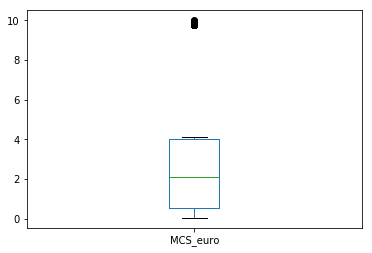

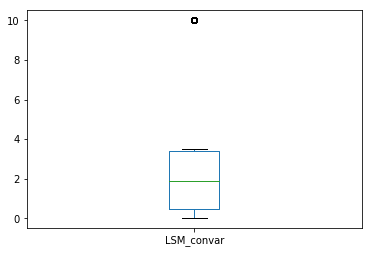

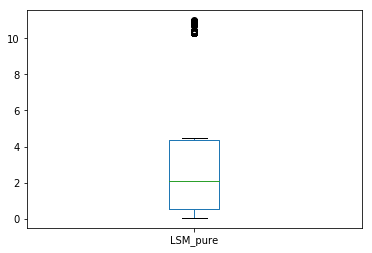

In [69]:
out.plot.box()
out2.plot.box()
out3.plot.box()

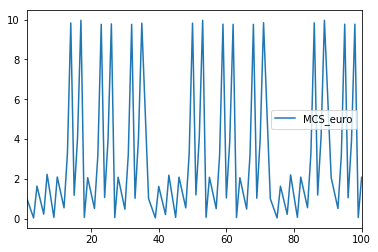

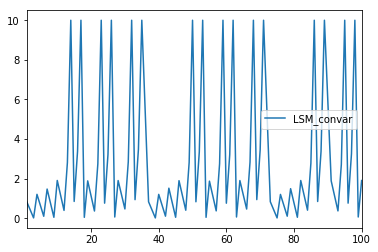

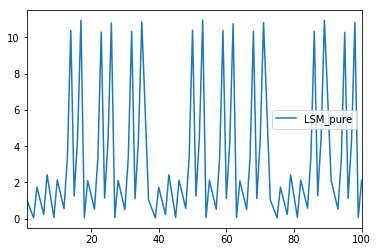

In [72]:
out[:80].plot()
out2[:80].plot()
out3[:80].plot()